# Plot Metrics

In [55]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from torch.jit import load

In [59]:
model_identifier = 'bi_lambda-30_lb-10'
split = 'test'
df = pd.read_csv(f'results/{model_identifier}/evaluation_{split}.csv')
df['compression_ratio'] = 16 / ((16 + 20) * df.occupancy * df.keep_ratio)

cutoff = 6.
df_cut = df[ df.cutoff == cutoff ]
df_cut.describe() 
df_cut.to_csv(f'results/{model_identifier}/test_performance_all-me.csv')

## Metrics as a function occupancy 

In [3]:
def plot_metrics(df, 
                 cutoff=None, 
                 width=4, 
                 metrics=('l1', 'l2', 'recall', 'precision')):
    """
    Plot metrics.
    """
    
    if cutoff is None:
        df_cut = df[ df.cutoff.isna() ]
    else:
        df_cut = df[ df.cutoff == cutoff ]

    fig, axes = plt.subplots(1, len(metrics), figsize=(len(metrics) * width, width))
    
    X = df_cut['occupancy']
    for metric, ax in zip(metrics, axes):
        Y = df_cut[metric]
        mean = Y.mean()
        
        ax.scatter(X, Y, s=.5)
        
        ax.set_xlabel('occupancy')
        ax.set_ylabel(metric)
        ax.grid(which='both')
        ax.axhline(mean, color='b', label=f'{metric} mean = {mean:.4f}')
        ax.set_title(f'{model_identifier}, cutoff={cutoff:.1f}')
        ax.legend()
    
    fig.tight_layout()

In [14]:
def sample_location(shape, num_samples):
    coords = np.column_stack(list(np.random.randint(0, size, num_samples) 
                                  for size in shape))
    return tuple(coords.T)

def sample_values(recon_path, 
                  cutoff=None, 
                  num_frames=None, 
                  num_sampled_values=1000):
    """
    """
    fnames = list(recon_path.glob('*npz'))
    
    if num_frames is not None:
        fnames = np.random.choice(fnames, num_frames, replace=True)
    
    data_values, reco_values = [], []
    
    for fname in tqdm(fnames, total=len(fnames)):
        with np.load(fname) as handle:
            data = handle['data']
            
            reco_reg = handle['reco_reg']
            reco_clf = handle['reco_clf']
            reco = reco_reg * (reco_clf > .5)
            
            if cutoff is not None:
                reco[reco < cutoff] = 0 

            locations = sample_location(data.shape, num_sampled_values)
            data_values.append(data[locations])
            reco_values.append(reco[locations])
    
    data_values = np.array(data_values).flatten()
    reco_values = np.array(reco_values).flatten()     

    return data_values, reco_values

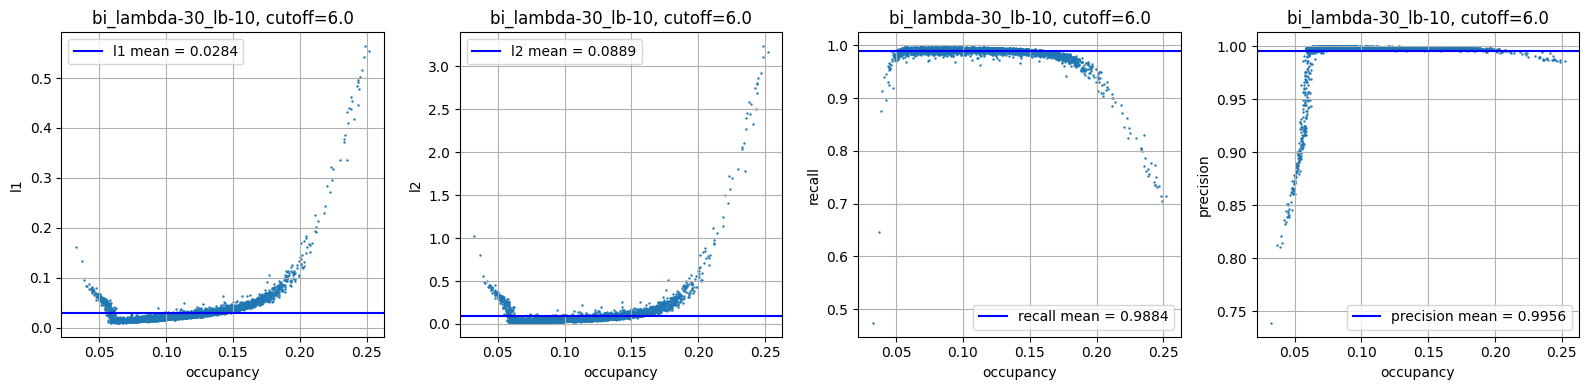

In [5]:
cutoff = 6.
plot_metrics(df, cutoff=cutoff)

In [15]:
recon_path = Path('reconstruction/')/model_identifier
num_frames = 2500
num_sampled_values = 2000

data_values, reco_values = sample_values(recon_path, 
                                         cutoff=cutoff, 
                                         num_frames=num_frames, 
                                         num_sampled_values=num_sampled_values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:42<00:00, 24.39it/s]


## 1D histogram

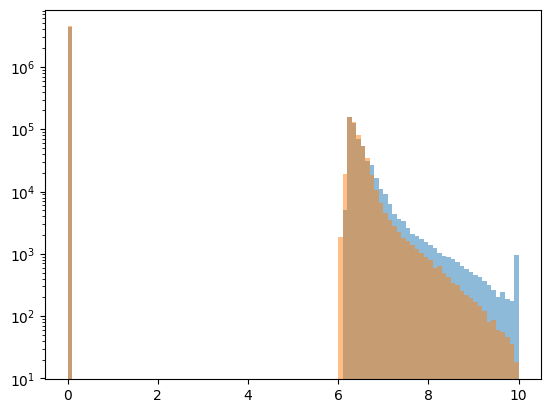

In [16]:
fig, ax = plt.subplots(1, 1)
ax.set_yscale('log')
bins = np.linspace(0, 10, 101)

height_data = ax.hist(data_values, bins=bins, alpha=.5)[0]
height_reco = ax.hist(reco_values, bins=bins, alpha=.5)[0]

df_hist = pd.DataFrame(data = {'location'    : (bins[1:] + bins[:-1]) / 2., 
                               'height_data' : height_data, 
                               'height_reco' : height_reco})
df_hist.to_csv(f'results/hist_1d.csv', index=False, float_format='%.6f')

## 2D histogram

In [40]:
df_sample = pd.DataFrame(data={'data': data_values, 'reco': reco_values})

204


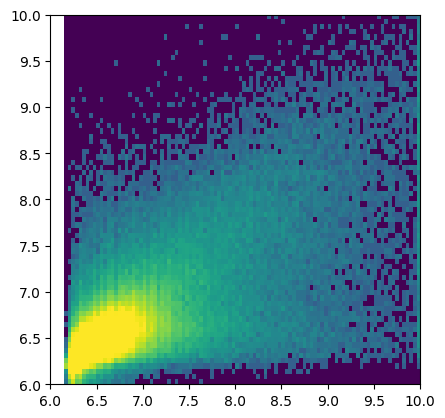

In [52]:
# for fname_suffix in fname_suffixes:
    # df = pd.read_csv(f'data/samples_{fname_suffix}.csv')
    # df_sel = df[ (df.data >= 6) & (df.reco >= 6) ]
    # data, reco = df_sel.data.values, df_sel.reco.values

df_sample_sel = df_sample[ (df_sample.data >= 6) & (df_sample.reco >= 6) ]
fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)
height = ax.hist2d(df_sample_sel.data.values, df_sample_sel.reco.values, 
                   bins=100, norm=mcolors.PowerNorm(.2, vmin=0, vmax=400))[0]
ax.set_xlim(6, 10)
ax.set_ylim(6, 10)
print(height.argmax())

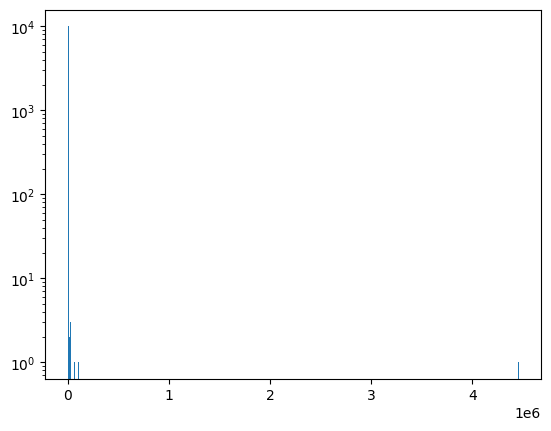

In [34]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(height.flatten(), bins=500)
ax.set_yscale('log')

In [29]:
height.shape

(100, 100)